#**Mounting Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Loading Pre-Processed Data from Drive**

In [ ]:
import pandas as pd

df_preprocessed = pd.read_csv('/content/drive/MyDrive/Computational Intelligence in Automation/preprocessed_data.csv')
display(df_preprocessed)

,sentiment,text
0,0,that bummer shoulda got david carr third day
1,0,upset cant updat facebook text might cri resul...
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav im mad cant see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdbcom cool hear old walt interview â
1599997,1,readi mojo makeov ask detail
1599998,1,happi th birthday boo alll time tupac amaru sh...


#**Removing NaN Values**

In [ ]:
# Check for NaN values in 'text' column
print("Checking for NaN values in 'text' column:")
print(df_preprocessed['text'].isna().sum())

Checking for NaN values in 'text' column:
7211


In [ ]:
# Handle NaN values (remove rows with NaN in 'text' column)
df_final = df_preprocessed.dropna(subset=['text'])

#**Train-Test Set Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_final['text'], df_final['sentiment'], test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1274231,)
(318558,)
(1274231,)
(318558,)


#**Vectorization (Bag of Words)**

Due to time complexity and RAM constraints, the data is vectorized with 5000 features


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Step 2: Create Bag-of-Words Representation
vectorizer = CountVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(1274231, 5000)
(318558, 5000)


#**Logistic Regression (Non-Private)**

Accuracy without DP: 77.65%


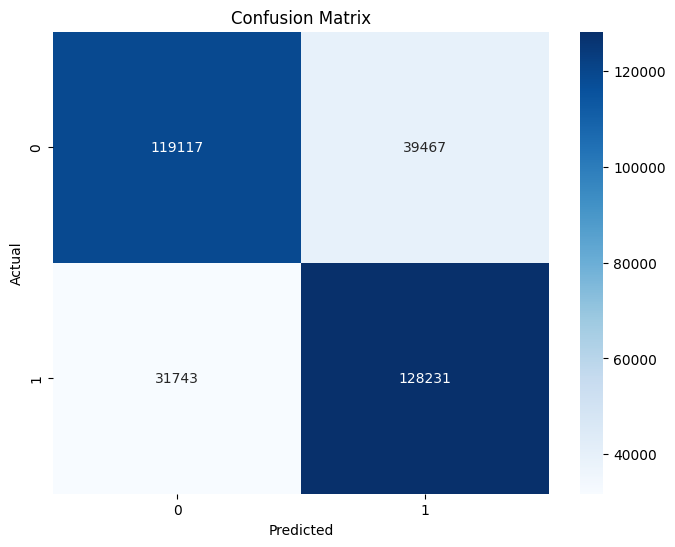

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train logistic regression without differential privacy
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

# Evaluate the model
y_pred = model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy without DP: {accuracy * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# Save the plot as an SVG file
plt.savefig("confusion_matrix.svg", format='svg')

plt.show()

#**Model with Differential Privacy**

In [ ]:
pip install diffprivlib

###**Epsilon = 0.1**

Accuracy with epsilon=0.1: 0.5324870196322177
Accuracy with epsilon=0.5: 0.5235404541716108
Accuracy with epsilon=1.0: 0.5377105582029018
Accuracy with epsilon=5.0: 0.6002140897418994


/usr/local/lib/python3.10/dist-packages/diffprivlib/models/logistic_regression.py:423: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/logistic_regression.py:423: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)


Accuracy with epsilon=10.0: 0.6241375196981398


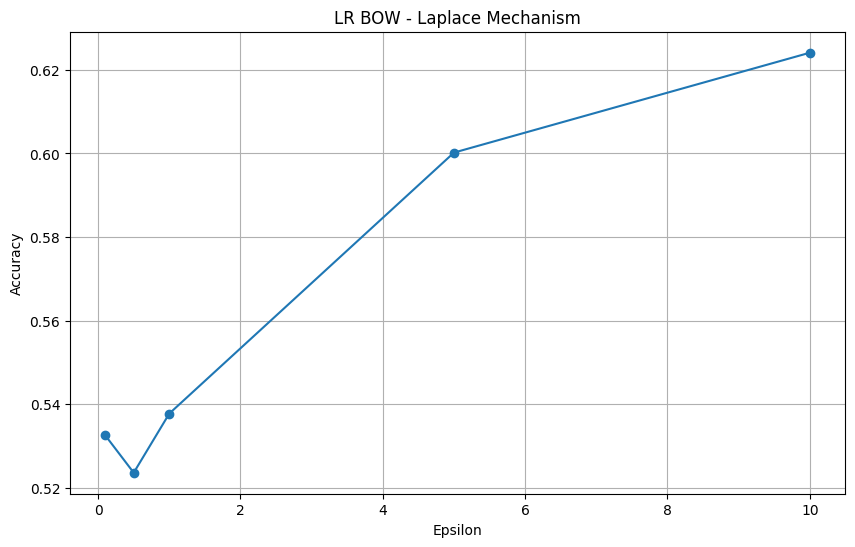

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from diffprivlib.models import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc


def train_model_with_dp(X_train, X_test, y_train, y_test, epsilon, batch_size=1000):
    # Initialize the differentially private logistic regression model
    model = LogisticRegression(epsilon=epsilon, data_norm=2.0)  # Adjust data_norm according to your data

    # Train the model in batches
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Convert to numpy array if necessary
        X_batch = X_batch.toarray() if isinstance(X_batch, csr_matrix) else X_batch

        # Train the model on the batch
        model.fit(X_batch, y_batch)

        # Clear memory after each batch
        del X_batch, y_batch
        gc.collect()

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Define a range of epsilon values to test
epsilon_values = [0.1, 0.5, 1.0, 5.0, 10.0]
batch_size = 100000  # Adjust as needed

accuracies = []

# Iterate over different epsilon values
for epsilon in epsilon_values:
    accuracy = train_model_with_dp(X_train_bow, X_test_bow, y_train, y_test, epsilon, batch_size)
    accuracies.append(accuracy)
    print(f"Accuracy with epsilon={epsilon}: {accuracy}")

# Plot accuracy vs epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o')
plt.title('LR BOW - Laplace Mechanism')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
